# Modelo de previsão de temperaturas

## 1 Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
np.random.seed(0)

## 2 - Carregamento e Preparação dos Dados

In [2]:
data = np.sin(np.linspace(0, 20, 500) * np.pi) * 10 + 25 + np.random.normal(0, 1, 500)
df = pd.DataFrame(data, columns=['Temperatura'])
print(df.head())

   Temperatura
0    26.764052
1    26.655988
2    28.470515
3    30.929162
4    31.693920


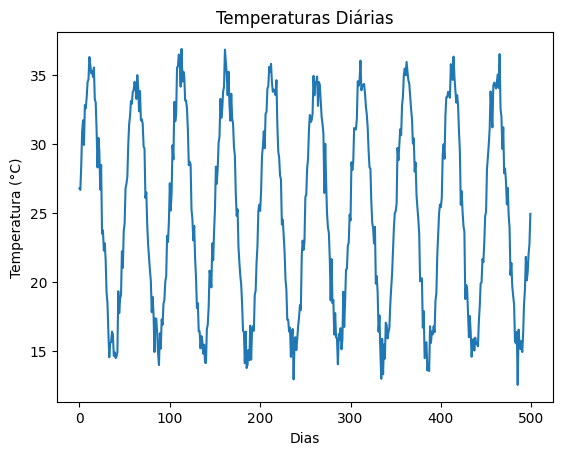

In [3]:
plt.plot(df)
plt.title('Temperaturas Diárias')
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.show()

## 3 - Pré-processamento

In [4]:
# Função para criar janelas
def create_dataset(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [5]:
# (70% treino, 15% validação, 15% teste)
train_size = int(len(df) * 0.7)
validation_size = int(len(df) * 0.15)

train_data, validation_data, test_data = df[0:train_size], df[train_size:train_size + validation_size], df[train_size + validation_size:]

# Normalização
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
validation_scaled = scaler.transform(validation_data)
test_scaled = scaler.transform(test_data)

X_train, y_train = create_dataset(train_scaled)
X_validation, y_validation = create_dataset(validation_scaled)
X_test, y_test = create_dataset(test_scaled)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, X_validation.shape, X_test.shape)

(320, 30, 1) (45, 30, 1) (45, 30, 1)


## 4 - Construção da rede LSTM

In [6]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Treinando o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.2436 - val_loss: 0.0750
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0678 - val_loss: 0.0496
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0441 - val_loss: 0.0423
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0376 - val_loss: 0.0301
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0246 - val_loss: 0.0199
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0161 - val_loss: 0.0101
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

## 5- Validação do modelo

In [8]:
# Avaliando o modelo
loss = model.evaluate(X_test, y_test)
print(f'Loss no conjunto de teste: {loss}')

# Fazendo previsões
y_pred = model.predict(X_test)

# Invertendo a normalização das previsões e valores reais
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0032
Loss no conjunto de teste: 0.003128079231828451
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


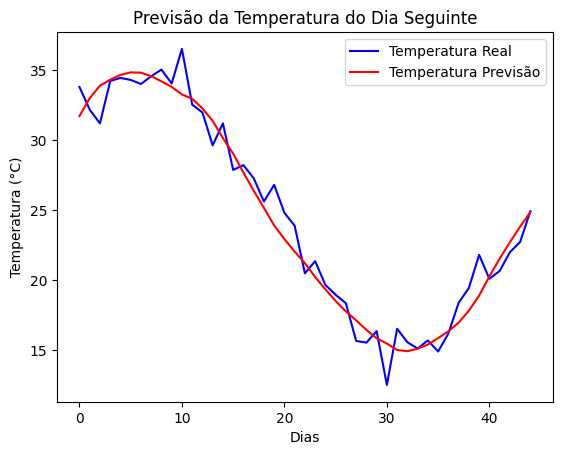

In [9]:
plt.plot(y_test_rescaled, color='blue', label='Temperatura Real')
plt.plot(y_pred_rescaled, color='red', label='Temperatura Previsão')
plt.title('Previsão da Temperatura do Dia Seguinte')
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()